In [ ]:
!pip install open3d


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
images_path = ("/content/calibration_images/*.jpg")

# Load images
images = [cv2.imread(file) for file in glob.glob(str(images_path))]

In [ ]:
#Calibrating
import cv2
import numpy as np
import glob

def calculate_intrinsic_matrix(image_path, grid_x, grid_y):
    """Calculates the intrinsic camera matrix using chessboard images.

    Args:
        image_path (str): Path to the folder containing chessboard images (e.g., 'path/to/images/*.jpg')
        grid_x (int): Number of inner corners in the chessboard's x-direction
        grid_y (int): Number of inner corners in the chessboard's y-direction

    Returns:
        K (numpy.ndarray): Intrinsic camera matrix
    """
    print("Starting intrinsic matrix calculation...")

    # Define the chessboard size and criteria for corner detection and refinement
    chessboard_size = (grid_x, grid_y)
    termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Prepare object points based on the chessboard size
    object_points = np.zeros((chessboard_size[0] * chessboard_size[1], 3), dtype=np.float32)
    object_points[:, :2] = np.mgrid[0:grid_x, 0:grid_y].T.reshape(-1, 2)

    # Arrays to store object points and image points from all images
    all_obj_points = []
    all_img_points = []

    # Loop over images at the provided path
    for image_file in glob.glob(image_path):
        image = cv2.imread(image_file)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        success, corners = cv2.findChessboardCorners(gray_image, chessboard_size, None)

        if success:
            # Refine corner position
            corners_refined = cv2.cornerSubPix(gray_image, corners, (11, 11), (-1, -1), termination_criteria)
            all_obj_points.append(object_points)
            all_img_points.append(corners_refined)

    # Perform camera calibration to get only the intrinsic matrix
    _, K, _, _, _ = cv2.calibrateCamera(all_obj_points, all_img_points, gray_image.shape[::-1], None, None)

    print("Intrinsic Matrix Calculation Successful.\nIntrinsic Matrix:\n", K)

    return K

# Usage example:
if __name__ == '__main__':
    intrinsic_matrix = calculate_intrinsic_matrix('/content/calibration_images/*.jpg', 10, 7)

Starting intrinsic matrix calculation...
Intrinsic Matrix Calculation Successful.
Intrinsic Matrix:
 [[716.69619459   0.         481.27153917]
 [  0.         721.89937617 362.52399202]
 [  0.           0.           1.        ]]


In [ ]:
#Feature.py

import cv2
import os
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import least_squares
import open3d as o3d
from scipy.interpolate import RectBivariateSpline

def MatchSIFT(loc1, des1, loc2, des2):
    """
    Find the matches of SIFT features between two images

    Parameters
    ----------
    loc1 : ndarray of shape (n1, 2)
        Keypoint locations in image 1
    des1 : ndarray of shape (n1, 128)
        SIFT descriptors of the keypoints image 1
    loc2 : ndarray of shape (n2, 2)
        Keypoint locations in image 2
    des2 : ndarray of shape (n2, 128)
        SIFT descriptors of the keypoints image 2

    Returns
    -------
    x1 : ndarray of shape (m, 2)
        The matched keypoint locations in image 1
    x2 : ndarray of shape (m, 2)
        The matched keypoint locations in image 2
    ind1 : ndarray of shape (m,)
        The indices of x1 in loc1
    """

    # Initialize NearestNeighbors instances for both sets of descriptors
    nn1 = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(des1)
    nn2 = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(des2)

    # set the ratio threshold for the ratio test
    ratio_threshold = 0.8


    # Find the 2 nearest neighbors in image 2 for each keypoint in image 1
    distances1, indices1 = nn2.kneighbors(des1) # shape of (n1, 2)

    # Apply the ratio test for image 1 keypoints
    ratio_mask1 = distances1[:, 0] < ratio_threshold * distances1[:, 1]

    # Find the 2 nearest neighbors in image 1 for each keypoint in image 2
    distances2, indices2 = nn1.kneighbors(des2) # shape of (n2, 2)

    # Apply the ratio test for image 2 keypoints
    ratio_mask2 = distances2[:, 0] < ratio_threshold * distances2[:, 1]

    # Filter matches based on the ratio test
    matches1 = np.where(ratio_mask1)[0] # indices of the keypoints in image 1 that pass the ratio test
    matches2 = np.where(ratio_mask2)[0] # indices of the keypoints in image 2 that pass the ratio test


    # Ensure bidirectional consistency
    # This means for a match to be valid, the nearest neighbor of a keypoint in one image
    # must be the same keypoint in the other image that considers the first keypoint as its nearest neighbor.
    good_matches1 = []
    good_matches2 = []
    good_indices1 = []

    for m1 in matches1:
        m2 = indices1[m1, 0]  # Best match in image 2 for keypoint m1 in image 1
        if ratio_mask2[m2] and indices2[m2, 0] == m1:  # Check if the best match in image 1 for keypoint m2 is indeed m1, and m2 passes the ratio test
            good_matches1.append(m1)
            good_matches2.append(m2)
            good_indices1.append(m1) #append to the list of matched indices of x1 in loc1

    # Gather the matched keypoints locations based on the filtered indices

    x1 = loc1[good_matches1]
    x2 = loc2[good_matches2]
    ind1 = np.array(good_indices1)

    return x1, x2, ind1



def EstimateE(x1, x2):
    """
    Estimate the essential matrix, which is a rank 2 matrix with singular values
    (1, 1, 0)

    Parameters
    ----------
    x1 : ndarray of shape (n, 2)
        Set of correspondences in the first image
    x2 : ndarray of shape (n, 2)
        Set of correspondences in the second image

    Returns
    -------
    E : ndarray of shape (3, 3)
        The essential matrix
    """

    # We perform 8 point algorithm

    #construct the matrix A
    A = []
    for p1, p2 in zip(x1, x2):
        x, y = p1
        xp, yp = p2
        A.append([xp*x, xp*y, xp, yp*x, yp*y, yp, x, y, 1])
    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    E = V[-1].reshape(3, 3)
    # Enforce the rank 2 constraint
    U, S, Vt = np.linalg.svd(E)
    S = np.array([1, 1, 0])
    E = U @ np.diag(S) @ Vt
    return E




def EstimateE_RANSAC(x1, x2, ransac_n_iter, ransac_thr):
    """
    Estimate the essential matrix robustly using RANSAC

    Parameters
    ----------
    x1 : ndarray of shape (n, 2)
        Set of correspondences in the first image
    x2 : ndarray of shape (n, 2)
        Set of correspondences in the second image
    ransac_n_iter : int
        Number of RANSAC iterations
    ransac_thr : float
        Error threshold for RANSAC

    Returns
    -------
    E : ndarray of shape (3, 3)
        The essential matrix
    inlier : ndarray of shape (k,)
        The inlier indices
    """

    max_inliers = []
    best_E = None

    for _ in range(ransac_n_iter):
        # randomly select 8 pairs of matched keypoints to perform 8 points algorithm
        indices = np.random.choice(x1.shape[0], 8, replace=False)
        E = EstimateE(x1[indices], x2[indices])
        # calculate the error for each pair of matched keypoints
        x1_homogeneous = np.hstack((x1, np.ones((x1.shape[0], 1))))
        x2_homogeneous = np.hstack((x2, np.ones((x2.shape[0], 1))))

        errors = np.abs(np.diag(x2_homogeneous @ E @ x1_homogeneous.T))

        inliers = np.where(errors < ransac_thr)[0]

        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            best_E = E

    E = best_E
    inlier = max_inliers

    return E, inlier

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines '''
    r,c, _ = img1.shape
    # img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    # img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img3 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img3 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img4 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img3,img4

def BuildFeatureTrack(Im, K):
    """
    Build feature track

    Parameters
    ----------
    Im : ndarray of shape (N, H, W, 3)
        Set of N images with height H and width W
    K : ndarray of shape (3, 3)
        Intrinsic parameters

    Returns
    -------
    track : ndarray of shape (N, F, 2)
        The feature tensor, where F is the number of total features
    """

    print("Building feature track")

    # K[2][2] = 1
    assert K[2][2] == 1, "The last element of the last row of K must be 1.0."

    loc_list = []
    des_list = []

    N = Im.shape[0]
    sift = cv2.xfeatures2d.SIFT_create()
    #Extract SIFT features for each image
    print("Extracting SIFT features")
    for i in range(N):
        kp, des = sift.detectAndCompute(Im[i], None)
        loc = np.array([loc.pt for loc in kp])
        loc_list.append(loc)
        des_list.append(des)
        print(f"Extracted {loc.shape[0]} SIFT features from image {i+1}")

    track = np.empty((N, 0, 2))

    for i in range(N):
        track_i = -1 * np.ones((N, loc_list[i].shape[0], 2))
        for j in range(i+1, N):
            x1, x2, ind1 = MatchSIFT(loc_list[i], des_list[i], loc_list[j], des_list[j])
            print(f'Found {x1.shape[0]} matches between image {i+1} and image {j+1}')
            #map to normalized coordinate by multiplying K inverse
            x1 = np.dot(np.linalg.inv(K), np.vstack((x1.T, np.ones(x1.shape[0])))).T
            x2 = np.dot(np.linalg.inv(K), np.vstack((x2.T, np.ones(x2.shape[0])))).T
            #drop the last column to get the normalized coordinates
            x1 = x1[:, :2]
            x2 = x2[:, :2]
            E, inlier_indices = EstimateE_RANSAC(x1, x2, 500, 0.001)
            feature_indices = ind1[inlier_indices] #get the feature indices which are considered as inliers

            #update the track_i so that the inliers are stored in the correct indices
            track_i[i, feature_indices, :] = x1[inlier_indices]
            track_i[j, feature_indices, :] = x2[inlier_indices]

            import matplotlib.pyplot as plt
            F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)
            # Find epilines corresponding to points in right image (second image) and
            # drawing its lines on left image
            pt1 = np.int32(K @ np.vstack((x1[inlier_indices].T, np.ones(x1[inlier_indices].shape[0]))))
            pt2 = np.int32(K @ np.vstack((x2[inlier_indices].T, np.ones(x2[inlier_indices].shape[0]))))
            pt1 = pt1[:2].T
            pt2 = pt2[:2].T
            lines1 = cv2.computeCorrespondEpilines(pt2.reshape(-1,1,2), 2,F)
            # breakpoint()
            I = Im.copy()
            lines1 = lines1.reshape(-1,3)
            img5,img6 = drawlines(I[i],I[j],lines1,pt1,pt2)
            # Find epilines corresponding to points in left image (first image) and
            # drawing its lines on right image
            lines2 = cv2.computeCorrespondEpilines(pt1.reshape(-1,1,2), 1,F)
            lines2 = lines2.reshape(-1,3)
            img3,img4 = drawlines(I[j],I[i],lines2,pt2,pt1)
            plt.subplot(121),plt.imshow(img5)
            plt.title(f'epipolar line of image{i+1} for image {j+1}', fontsize=10), plt.xticks([]), plt.yticks([])
            plt.subplot(122),plt.imshow(img3)
            plt.title(f'epipolar line of image{j+1} for image {i+1}', fontsize=10), plt.xticks([]), plt.yticks([])
            plt.savefig(f'/content/epipolar_visualization/epipolar_{i}_{j}.png')
        valid_feature_mask = np.sum(track_i[i], axis=-1) != -2 #check if the feature is matched in at least one
        track_i = track_i[:, valid_feature_mask]
        print(f'Found {track_i.shape[1]} features in image {i+1}')
        track = np.concatenate((track, track_i), axis=1)

    return track

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# camera_pose.py


def GetCameraPoseFromE(E):
    """
    Find four conﬁgurations of rotation and camera center from E

    Parameters
    ----------
    E : ndarray of shape (3, 3)
        Essential matrix

    Returns
    -------
    R_set : ndarray of shape (4, 3, 3)
        The set of four rotation matrices
    C_set : ndarray of shape (4, 3)
        The set of four camera centers
    """

    U, _, Vt = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

    R1 = U @ W @ Vt
    R2 = U @ W.T @ Vt
    if np.linalg.det(R1) < 0:  # Ensure proper rotation matrix with determinant 1
        R1 = -R1
    if np.linalg.det(R2) < 0:
        R2 = -R2

    t1 = U[:, 2]
    t2 = -U[:, 2]

    # Camera centers calculated as -R.T * t
    C1 = -R1.T @ t1
    C2 = -R1.T @ t2
    C3 = -R2.T @ t1
    C4 = -R2.T @ t2

    R_set = np.array([R1, R1, R2, R2])
    C_set = np.array([C1, C2, C3, C4])

    return R_set, C_set


def Triangulation(P1, P2, track1, track2):
    """
    Use the linear triangulation method to triangulation the point

    Parameters
    ----------
    P1 : ndarray of shape (3, 4)
        Camera projection matrix 1
    P2 : ndarray of shape (3, 4)
        Camera projection matrix 2
    track1 : ndarray of shape (n, 2)
        Point correspondences from pose 1
    track2 : ndarray of shape (n, 2)
        Point correspondences from pose 2

    Returns
    -------
    X : ndarray of shape (n, 3)
        The set of 3D points
    """
    assert track1.shape == track2.shape, "track1 and track2 must have the same shape"
    n = track1.shape[0]

    X = -1 * np.ones((n, 3))
    for i in range(n):
        x1, y1 = track1[i]
        x2, y2 = track2[i]
        if x1 == -1 or x2 == -1 or y1 == -1 or y2 == -1:
            continue
        A = np.array([
            x1 * P1[2] - P1[0],
            y1 * P1[2] - P1[1],
            x2 * P2[2] - P2[0],
            y2 * P2[2] - P2[1]
        ])

        _, _, Vt = np.linalg.svd(A)
        point_3d = Vt[-1]
        point_3d /= point_3d[-1]
        X[i] = point_3d[:-1]

    return X



def EvaluateCheirality(P1, P2, X):
    """
    Evaluate the cheirality condition for the 3D points

    Parameters
    ----------
    P1 : ndarray of shape (3, 4)
        Camera projection matrix 1
    P2 : ndarray of shape (3, 4)
        Camera projection matrix 2
    X : ndarray of shape (n, 3)
        Set of 3D points

    Returns
    -------
    valid_index : ndarray of shape (n,)
        The binary vector indicating the cheirality condition, i.e., the entry
        is 1 if the point is in front of both cameras, and 0 otherwise
    """

    R1, t1 = P1[:, :3], P1[:, 3]
    R2, t2 = P2[:, :3], P2[:, 3]
    C1, C2 = -R1.T @ t1, -R2.T @ t2

    mask1 = np.sum(X, axis=-1) != -3
    mask2 = np.logical_and(np.dot(R1[2], (X - C1).T) > 0, np.dot(R2[2], (X - C2).T) > 0)

    valid_index = np.logical_and(mask1, mask2)


    return valid_index



def EstimateCameraPose(track1, track2):
    """
    Return the best pose conﬁguration

    Parameters
    ----------
    track1 : ndarray of shape (n, 2)
        Point correspondences from pose 1
    track2 : ndarray of shape (n, 2)
        Point correspondences from pose 2

    Returns
    -------
    R : ndarray of shape (3, 3)
        The rotation matrix
    C : ndarray of shape (3,)
        The camera center
    X : ndarray of shape (F, 3)
        The set of reconstructed 3D points
    """
    # Only use the features that are visible in both images
    feature_mask = np.logical_and(np.sum(track1, axis=-1) != -2, np.sum(track2, axis=-1) != -2)
    x1, x2 = track1[feature_mask], track2[feature_mask]
    featureIdx = np.asarray(np.nonzero(feature_mask)[0])


    # Estimate the essential matrix
    E, inlier = EstimateE_RANSAC(x1, x2, 200, 0.01)
    # Get 4 possible camera poses
    R_set, C_set = GetCameraPoseFromE(E)

    P1 = np.eye(3, 4)
    valid_points = 0

    for i in range(4):
        P2 = np.hstack([R_set[i], -(R_set[i] @ C_set[i]).reshape((3, 1))])
        # Triangulate points
        X_3d = Triangulation(P1, P2, track1, track2)
        # Filter out points based on cheirality
        valid_index = EvaluateCheirality(P1, P2, X_3d)
        print(f"Valid points: {np.sum(valid_index)} for camera pose {i}")
        if np.sum(valid_index) > valid_points:
            valid_points = np.sum(valid_index)
            R = R_set[i]
            C = C_set[i]
            X = -1 * np.ones((track1.shape[0], 3))
            X[valid_index] = X_3d[valid_index]

    return R, C, X

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#Utils.py


def Rotation2Quaternion(R):
    """
    Convert a rotation matrix to quaternion

    Parameters
    ----------
    R : ndarray of shape (3, 3)
        Rotation matrix

    Returns
    -------
    q : ndarray of shape (4,)
        The unit quaternion (w, x, y, z)
    """
    q = np.empty([4,])

    tr = np.trace(R)
    if tr < 0:
        i = R.diagonal().argmax()
        j = (i + 1) % 3
        k = (j + 1) % 3

        q[i] = np.sqrt(1 - tr + 2 * R[i, i]) / 2
        q[j] = (R[j, i] + R[i, j]) / (4 * q[i])
        q[k] = (R[k, i] + R[i, k]) / (4 * q[i])
        q[3] = (R[k, j] - R[j, k]) / (4 * q[i])
    else:
        q[3] = np.sqrt(1 + tr) / 2
        q[0] = (R[2, 1] - R[1, 2]) / (4 * q[3])
        q[1] = (R[0, 2] - R[2, 0]) / (4 * q[3])
        q[2] = (R[1, 0] - R[0, 1]) / (4 * q[3])

    q /= np.linalg.norm(q)
    # Rearrange (x, y, z, w) to (w, x, y, z)
    q = q[[3, 0, 1, 2]]

    return q



def Quaternion2Rotation(q):
    """
    Convert a quaternion to rotation matrix

    Parameters
    ----------
    q : ndarray of shape (4,)
        Unit quaternion (w, x, y, z)

    Returns
    -------
    R : ndarray of shape (3, 3)
        The rotation matrix
    """
    w = q[0]
    x = q[1]
    y = q[2]
    z = q[3]

    R = np.empty([3, 3])
    R[0, 0] = 1 - 2 * y**2 - 2 * z**2
    R[0, 1] = 2 * (x*y - z*w)
    R[0, 2] = 2 * (x*z + y*w)

    R[1, 0] = 2 * (x*y + z*w)
    R[1, 1] = 1 - 2 * x**2 - 2 * z**2
    R[1, 2] = 2 * (y*z - x*w)

    R[2, 0] = 2 * (x*z - y*w)
    R[2, 1] = 2 * (y*z + x*w)
    R[2, 2] = 1 - 2 * x**2 - 2 * y**2

    return R
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#pnp.py



def PnP(X, x):
    """
    Implement the linear perspective-n-point algorithm

    Parameters
    ----------
    X : ndarray of shape (n, 3)
        Set of reconstructed 3D points
    x : ndarray of shape (n, 2)
        2D points of the new image

    Returns
    -------
    R : ndarray of shape (3, 3)
        The rotation matrix
    C : ndarray of shape (3,)
        The camera center
    """
    n = X.shape[0]

    # Building the matrix A for AX = 0 formulation
    A = np.zeros((2 * n, 12))
    for i in range(n):
        X_i = X[i]
        x_i = x[i]
        A[2*i] = [X_i[0], X_i[1], X_i[2], 1, 0, 0, 0, 0, -x_i[0]*X_i[0], -x_i[0]*X_i[1], -x_i[0]*X_i[2], -x_i[0]]
        A[2*i+1] = [0, 0, 0, 0, X_i[0], X_i[1], X_i[2], 1, -x_i[1]*X_i[0], -x_i[1]*X_i[1], -x_i[1]*X_i[2], -x_i[1]]

    # Using SVD to solve AX = 0
    _, _, Vt = np.linalg.svd(A)
    P = Vt[-1].reshape(3, 4)  # Reshape the last row of V to form P

    # Decompose P to get R and C
    M = P[:, :3]  # Extract the first 3 columns
    C = P[:, 3]  # Extract the last column

    # Ensure M is a rotation matrix by making it orthogonal
    U, S, Vt = np.linalg.svd(M)
    R = U @ Vt
    R = R if np.linalg.det(R) > 0 else -R # check for det=-1

    C = -R.T @ P[:, 3] / S[0]

    # proj = (X - C[None]) @ R.T
    # sign = np.sign(proj[:, 2])
    # if np.sum(sign) < 0:
    #     R, C = -R, -C


    return R, C



def PnP_RANSAC(X, x, ransac_n_iter, ransac_thr):
    """
    Estimate pose using PnP with RANSAC

    Parameters
    ----------
    X : ndarray of shape (n, 3)
        Set of reconstructed 3D points
    x : ndarray of shape (n, 2)
        2D points of the new image
    ransac_n_iter : int
        Number of RANSAC iterations
    ransac_thr : float
        Error threshold for RANSAC

    Returns
    -------
    R : ndarray of shape (3, 3)
        The rotation matrix
    C : ndarray of shape (3,)
        The camera center
    inlier : ndarray of shape (n,)
        The indicator of inliers, i.e., the entry is 1 if the point is a inlier,
        and 0 otherwise
    """
    max_inliers = np.zeros(X.shape[0])
    best_R = None
    best_C = None

    X_mask = np.logical_and(np.logical_and(X[:, 0] != -1, X[:, 1] != -1), X[:, 2] != -1)
    track_i_mask = np.logical_and(x[:, 0] != -1, x[:, 1] != -1)
    mask = np.logical_and(X_mask, track_i_mask)
    mask_idx = np.where(mask)[0]
    masked_X = X[mask]
    masked_x = x[mask]

    for _ in range(ransac_n_iter):
        # Randomly sample subset of points for hypothetical inliers
        indices = np.random.choice(len(masked_X), size=6, replace=False)  # Need 6 points to perform linear matching
        R_estimate, C_estimate = PnP(masked_X[indices], masked_x[indices])

        # Project 3D points to 2D using the estimated pose and calculate error
        proj = (masked_X - C_estimate) @ R_estimate.T
        errors = np.sqrt((proj[:, 0] / proj[:, 2] - masked_x[:, 0])**2 + (proj[:, 1] / proj[:, 2] - masked_x[:, 1])**2)

        inliers = np.zeros(X.shape[0])
        inliers[mask_idx] = errors < ransac_thr


        if np.sum(inliers) > np.sum(max_inliers):
            max_inliers = inliers
            best_C = C_estimate
            best_R = R_estimate


    R, C = best_R, best_C
    inlier = max_inliers
    return R, C, inlier



def ComputePoseJacobian(p, X):
    """
    Compute the pose Jacobian

    Parameters
    ----------
    p : ndarray of shape (7,)
        Camera pose made of camera center and quaternion
    X : ndarray of shape (3,)
        3D point

    Returns
    -------
    dfdp : ndarray of shape (2, 7)
        The pose Jacobian
    """
    C = p[:3]
    q = p[3:]
    R = Quaternion2Rotation(q)
    x = R @ (X - C)

    u = x[0]
    v = x[1]
    w = x[2]
    du_dc = -R[0,:]
    dv_dc = -R[1,:]
    dw_dc = -R[2,:]
    # df_dc is in shape (2, 3)
    df_dc = np.stack([
        (w * du_dc - u * dw_dc) / (w**2),
        (w * dv_dc - v * dw_dc) / (w**2)
    ], axis=0)

    # du_dR = np.concatenate([X-C, np.zeros(3), X-C])
    # dv_dR = np.concatenate([np.zeros(3), X-C, X-C])
    # dw_dR = np.concatenate([np.zeros(3), np.zeros(3), X-C])
    du_dR = np.concatenate([X-C, np.zeros(3), np.zeros(3)])
    dv_dR = np.concatenate([np.zeros(3), X-C, np.zeros(3)])
    dw_dR = np.concatenate([np.zeros(3), np.zeros(3), X-C])
    # df_dR is in shape (2, 9)
    df_dR = np.stack([
        (w * du_dR - u * dw_dR) / (w**2),
        (w * dv_dR - v * dw_dR) / (w**2)
    ], axis=0)


    qw = q[0]
    qx = q[1]
    qy = q[2]
    qz = q[3]
    # dR_dq is in shape (9, 4)
    dR_dq = np.asarray([
        [0, 0, -4*qy, -4*qz],
        [-2*qz, 2*qy, 2*qx, -2*qw],
        [2*qy, 2*qz, 2*qw, 2*qx],
        [2*qz, 2*qy, 2*qx, 2*qw],
        [0, -4*qx, 0, -4*qz],
        [-2*qx, -2*qw, 2*qz, 2*qy],
        [-2*qy, 2*qz, -2*qw, 2*qx],
        [2*qx, 2*qw, 2*qz, 2*qy],
        [0, -4*qx, -4*qy, 0],
    ])

    dfdp = np.hstack([df_dc, df_dR @ dR_dq])

    return dfdp


def PnP_nl(R, C, X, x):
    """
    Update the pose using the pose Jacobian

    Parameters
    ----------
    R : ndarray of shape (3, 3)
        Rotation matrix refined by PnP
    c : ndarray of shape (3,)
        Camera center refined by PnP
    X : ndarray of shape (n, 3)
        Set of reconstructed 3D points
    x : ndarray of shape (n, 2)
        2D points of the new image

    Returns
    -------
    R_refined : ndarray of shape (3, 3)
        The rotation matrix refined by nonlinear optimization
    C_refined : ndarray of shape (3,)
        The camera center refined by nonlinear optimization
    """
    n = X.shape[0]
    q = Rotation2Quaternion(R)

    p = np.concatenate([C, q])
    n_iters = 20
    lamb = 1
    error = np.empty((n_iters,))
    for i in range(n_iters):
        R_i = Quaternion2Rotation(p[3:])
        C_i = p[:3]

        proj = (X - C_i[np.newaxis,:]) @ R_i.T
        proj = proj[:,:2] / proj[:,2,np.newaxis]

        H = np.zeros((7,7))
        J = np.zeros(7)
        for j in range(n):
            dfdp = ComputePoseJacobian(p, X[j,:])
            H = H + dfdp.T @ dfdp
            J = J + dfdp.T @ (x[j,:] - proj[j,:])

        delta_p = np.linalg.inv(H + lamb*np.eye(7)) @ J
        p += delta_p
        p[3:] /= np.linalg.norm(p[3:])

        error[i] = np.linalg.norm(proj - x)


    R_refined = Quaternion2Rotation(p[3:])
    C_refined = p[:3]
    return R_refined, C_refined

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Reconstruction.py




def FindMissingReconstruction(X, track_i):
    """
    Find the points that will be newly added

    Parameters
    ----------
    X : ndarray of shape (F, 3)
        3D points
    track_i : ndarray of shape (F, 2)
        2D points of the newly registered image

    Returns
    -------
    new_point : ndarray of shape (F,)
        The indicator of new points that are valid for the new image and are
        not reconstructed yet
    """

    X_mask = np.logical_and(np.logical_and(X[:, 0] != -1, X[:, 1] != -1), X[:, 2] != -1)
    track_i_mask = np.logical_and(track_i[:, 0] != -1, track_i[:, 1] != -1)
    new_point = np.logical_and(track_i_mask, ~X_mask)

    return new_point



def Triangulation_nl(X, P1, P2, x1, x2):
    """
    Refine the triangulated points

    Parameters
    ----------
    X : ndarray of shape (n, 3)
        3D points
    P1 : ndarray of shape (3, 4)
        Camera projection matrix 1
    P2 : ndarray of shape (3, 4)
        Camera projection matrix 2
    x1 : ndarray of shape (n, 2)
        Point correspondences from pose 1
    x2 : ndarray of shape (n, 2)
        Point correspondences from pose 2

    Returns
    -------
    X_new : ndarray of shape (n, 3)
        The set of refined 3D points
    """
    R1 = P1[:,:3]
    C1 = -R1.T @ P1[:,3]
    R2 = P2[:,:3]
    C2 = -R2.T @ P2[:,3]

    p1 = np.concatenate([C1, Rotation2Quaternion(R1)])
    p2 = np.concatenate([C2, Rotation2Quaternion(R2)])

    lamb = 0.005
    n_iter = 10
    X_new = X.copy()
    for i in range(X.shape[0]):
        pt = X[i,:]
        for j in range(n_iter):
            proj1 = R1 @ (pt - C1)
            proj1 = proj1[:2] / proj1[2]
            proj2 = R2 @ (pt - C2)
            proj2 = proj2[:2] / proj2[2]

            dfdX1 = ComputePointJacobian(pt, p1)
            dfdX2 = ComputePointJacobian(pt, p2)

            H1 = dfdX1.T @ dfdX1 + lamb * np.eye(3)
            H2 = dfdX2.T @ dfdX2 + lamb * np.eye(3)

            J1 = dfdX1.T @ (x1[i,:] - proj1)
            J2 = dfdX2.T @ (x2[i,:] - proj2)

            delta_pt = np.linalg.inv(H1) @ J1 + np.linalg.inv(H2) @ J2
            pt += delta_pt

        X_new[i,:] = pt

    return X_new


def ComputePointJacobian(X, p):
    """
    Compute the point Jacobian

    Parameters
    ----------
    X : ndarray of shape (3,)
        3D point
    p : ndarray of shape (7,)
        Camera pose made of camera center and quaternion

    Returns
    -------
    dfdX : ndarray of shape (2, 3)
        The point Jacobian
    """
    R = Quaternion2Rotation(p[3:])
    C = p[:3]
    x = R @ (X - C)

    u = x[0]
    v = x[1]
    w = x[2]
    du_dc = R[0, :]
    dv_dc = R[1, :]
    dw_dc = R[2, :]

    dfdX = np.stack([
        (w * du_dc - u * dw_dc) / (w**2),
        (w * dv_dc - v * dw_dc) / (w**2)
    ], axis=0)

    return dfdX



def SetupBundleAdjustment(P, X, track):
    """
    Setup bundle adjustment

    Parameters
    ----------
    P : ndarray of shape (K, 3, 4)
        Set of reconstructed camera poses
    X : ndarray of shape (J, 3)
        Set of reconstructed 3D points
    track : ndarray of shape (K, J, 2)
        Tracks for the reconstructed cameras

    Returns
    -------
    z : ndarray of shape (7K+3J,)
        The optimization variable that is made of all camera poses and 3D points
    b : ndarray of shape (2M,)
        The 2D points in track, where M is the number of 2D visible points
    S : ndarray of shape (2M, 7K+3J)
        The sparse indicator matrix that indicates the locations of Jacobian computation
    camera_index : ndarray of shape (M,)
        The index of camera for each measurement
    point_index : ndarray of shape (M,)
        The index of 3D point for each measurement
    """
    n_cameras = P.shape[0]
    n_points = X.shape[0]

    n_projs = np.sum(track[:,:,0] != -1)
    b = np.zeros((2*n_projs,))
    S = np.zeros((2*n_projs, 7*n_cameras+3*n_points), dtype=bool)
    k = 0
    camera_index = []
    point_index = []
    for i in range(n_cameras):
        for j in range(n_points):
            if track[i, j, 0] != -1:
                if i not in (0, 1):
                    S[2*k : 2*(k+1), 7*i : 7*(i+1)] = 1
                S[2*k : 2*(k+1), 7*n_cameras+3*j : 7*n_cameras+3*(j+1)] = 1
                b[2*k : 2*(k+1)] = track[i, j, :]
                camera_index.append(i)
                point_index.append(j)
                k += 1
    camera_index = np.asarray(camera_index)
    point_index = np.asarray(point_index)

    z = np.zeros((7*n_cameras+3*n_points,))
    for i in range(n_cameras):
        R = P[i, :, :3]
        C = -R.T @ P[i, :, 3]
        q = Rotation2Quaternion(R)
        p = np.concatenate([C, q])
        z[7*i : 7*(i+1)] = p
    # for i in range(n_points):
    #     z[7*n_cameras+3*i : 7*n_cameras+3*(i+1)] = X[i, :]
    z[7*n_cameras:] = X.ravel()

    return z, b, S, camera_index, point_index



def MeasureReprojection(z, b, n_cameras, n_points, camera_index, point_index):
    """
    Evaluate the reprojection error

    Parameters
    ----------
    z : ndarray of shape (7K+3J,)
        Optimization variable
    b : ndarray of shape (2M,)
        2D measured points
    n_cameras : int
        Number of cameras
    n_points : int
        Number of 3D points
    camera_index : ndarray of shape (M,)
        Index of camera for each measurement
    point_index : ndarray of shape (M,)
        Index of 3D point for each measurement

    Returns
    -------
    err : ndarray of shape (2M,)
        The reprojection error
    """
    n_projs = camera_index.shape[0]
    f = np.zeros((2*n_projs,))
    for k, (i, j) in enumerate(zip(camera_index, point_index)):
        p = z[7*i : 7*(i+1)]
        X = z[7*n_cameras+3*j : 7*n_cameras+3*(j+1)]
        R = Quaternion2Rotation(p[3:] / np.linalg.norm(p[3:]))
        C = p[:3]
        proj = R @ (X - C)
        proj = proj / proj[2]
        f[2*k : 2*(k+1)] = proj[:2]
    err = b - f

    return err



def UpdatePosePoint(z, n_cameras, n_points):
    """
    Update the poses and 3D points

    Parameters
    ----------
    z : ndarray of shape (7K+3J,)
        Optimization variable
    n_cameras : int
        Number of cameras
    n_points : int
        Number of 3D points

    Returns
    -------
    P_new : ndarray of shape (K, 3, 4)
        The set of refined camera poses
    X_new : ndarray of shape (J, 3)
        The set of refined 3D points
    """
    P_new = np.empty((n_cameras, 3, 4))
    for i in range(n_cameras):
        p = z[7*i : 7*(i+1)]
        q = p[3:]
        R = Quaternion2Rotation(q / np.linalg.norm(q))
        C = p[:3]
        P_new[i,:,:] = R @ np.hstack([np.eye(3), -C[:,np.newaxis]])

    X_new = np.reshape(z[7*n_cameras:], (-1,3))

    return P_new, X_new



def RunBundleAdjustment(P, X, track):
    """
    Run bundle adjustment

    Parameters
    ----------
    P : ndarray of shape (K, 3, 4)
        Set of reconstructed camera poses
    X : ndarray of shape (J, 3)
        Set of reconstructed 3D points
    track : ndarray of shape (K, J, 2)
        Tracks for the reconstructed cameras

    Returns
    -------
    P_new : ndarray of shape (K, 3, 4)
        The set of refined camera poses
    X_new : ndarray of shape (J, 3)
        The set of refined 3D points
    """
    n_cameras = P.shape[0]
    n_points = X.shape[0]

    z0, b, S, camera_index, point_index  = SetupBundleAdjustment(P, X, track)

    res = least_squares(
        lambda x : MeasureReprojection(x, b, n_cameras, n_points, camera_index, point_index),
        z0,
        jac_sparsity=S,
        verbose=2
    )
    z = res.x

    err0 = MeasureReprojection(z0, b, n_cameras, n_points, camera_index, point_index)
    err = MeasureReprojection(z, b, n_cameras, n_points, camera_index, point_index)
    print('Reprojection error {} -> {}'.format(np.linalg.norm(err0), np.linalg.norm(err)))

    P_new, X_new = UpdatePosePoint(z, n_cameras, n_points)

    return P_new, X_new

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Building feature track
Extracting SIFT features
Extracted 672 SIFT features from image 1
Extracted 670 SIFT features from image 2
Extracted 725 SIFT features from image 3
Extracted 636 SIFT features from image 4
Extracted 660 SIFT features from image 5
Extracted 640 SIFT features from image 6
Extracted 596 SIFT features from image 7
Extracted 662 SIFT features from image 8
Extracted 633 SIFT features from image 9
Extracted 639 SIFT features from image 10
Extracted 638 SIFT features from image 11
Extracted 663 SIFT features from image 12
Extracted 670 SIFT features from image 13
Extracted 742 SIFT features from image 14
Found 330 matches between image 1 and image 2
Found 229 matches between image 1 and image 3
Found 259 matches between image 1 and image 4
Found 291 matches between image 1 and image 5
Found 271 matches between image 1 and image 6
Found 239 matches between image 1 and image 7
Found 189 matches between image 1 and image 8
Found 200 matches between image 1 and image 9
Found

<ipython-input-26-b4db44f49a34>:837: RuntimeWarning: invalid value encountered in divide
  proj2 = proj2[:2] / proj2[2]


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.9691e+01                                    2.71e+03    
       1              2         8.2312e+01      1.74e+01       3.09e+01       1.67e+03    
       2              3         2.4819e+01      5.75e+01       1.81e+00       1.80e+02    
       3              4         1.7674e+01      7.14e+00       3.21e+00       3.11e+02    
       4              5         1.6285e+01      1.39e+00       4.06e+00       6.72e+01    
       5              7         1.4667e+01      1.62e+00       2.54e-01       2.23e+01    
       6              9         1.4374e+01      2.93e-01       6.34e-02       1.39e+02    
       7             10         1.3726e+01      6.48e-01       1.59e-02       1.73e+01    
       8             11         1.3623e+01      1.03e-01       1.59e-02       1.28e+01    
       9             12         1.3552e+01      7.08e-02       1.59e-02       1.32e+01    

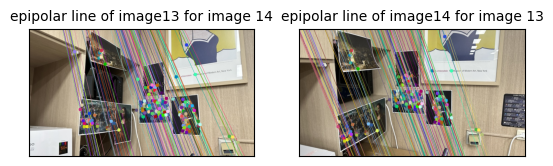

In [ ]:
#Main


def check_proj_error(idx, X, track, K, P, inlier=None):
    is_X_valid = np.all(X != -1, axis=1)
    if inlier is not None:
        is_inlier = np.zeros_like(is_X_valid)
        inlier_idx = np.where(inlier)[0]
        is_inlier[inlier_idx] = True
        is_X_valid = np.logical_and(is_X_valid, is_inlier)
    X_valid = X[is_X_valid]
    X_valid_h = np.hstack([X_valid, np.ones((X_valid.shape[0], 1))])
    x_proj_h = P[idx] @ X_valid_h.T
    x_proj = x_proj_h[:2] / x_proj_h[2]
    x_valid = track[idx][is_X_valid].T

    x_proj_K = K @ x_proj_h
    x_proj_K = x_proj_K[:2] / x_proj_K[2]
    x_proj_K = x_proj_K.T
    x_valid_K = K @ np.vstack([x_valid, np.ones((1, x_valid.shape[1]))])
    x_valid_K = x_valid_K[:2] / x_valid_K[2]
    x_valid_K = x_valid_K.T
    print("Ideal                        Projected")
    print(np.hstack([x_valid_K[:20], x_proj_K[:20]]))
    print(np.linalg.norm(x_proj_K - x_valid_K))

    return


if __name__ == '__main__':
    np.random.seed(100)
    K = np.asarray([
        [463.1, 0, 333.2],
        [0, 463.1, 187.5],
        [0, 0, 1]
    ])
    num_images = 14
    w_im = 672
    h_im = 378

    # Load input images
    Im = np.empty((num_images, h_im, w_im, 3), dtype=np.uint8)
    for i in range(num_images):
        im_file = '/content/images/image{:d}.jpg'.format(i + 1)
        im = cv2.imread(im_file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        Im[i,:,:,:] = im

    # Build feature track
    track = BuildFeatureTrack(Im, K)
    print("Track building over")

    track1 = track[0,:,:]
    track2 = track[1,:,:]

    # Estimate ﬁrst two camera poses
    R, C, X = EstimateCameraPose(track1, track2)

    output_dir = 'output1'
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    # Set of camera poses
    P = np.zeros((num_images, 3, 4))
    # Set first two camera poses
    P[0] = np.eye(3, 4)
    P[1] = np.hstack([R, -(R @ C).reshape((3, 1))])
    # print("camera 1, 2 initialized")
    # print("checking projection error")
    # check_proj_error(1, X, track, K, P)
    ransac_n_iter = 500
    ransac_thr = 0.01
    for i in range(2, num_images):
        print(f"adding camera number {i+1}")
        # Estimate new camera pose
        track_i = track[i, :, :]


        R, C, inlier = PnP_RANSAC(X, track_i, ransac_n_iter, ransac_thr)
        inlier_idx = np.where(inlier)[0]
        # breakpoint()
        print(f"number of inliers for camera{i+1}: {len(inlier_idx)}")
        if len(inlier_idx) > 0:
            R, C = PnP_nl(R, C, X[inlier_idx, :], track_i[inlier_idx, :])
        else:
            print(f"No inliers found for camera {i+1}. Skipping pose estimation.")
            continue

        P[i] = np.hstack([R, -(R @ C).reshape((3, 1))])

        for j in range(i):
            print(f"matching camera {j+1} with {i+1}")
            # Fine new points to reconstruct
            track_j = track[j, :, :]
            track_j_mask = np.logical_and(track_j[:, 0] != -1, track_j[:, 1] != -1)

            new_points = np.logical_and(FindMissingReconstruction(X, track_i), track_j_mask)
            new_points_idx = np.where(new_points)[0]
            print(f"new points added with camera {i+1} in iteration {j+1}: {len(new_points_idx)}")
            # Triangulate points
            new_X = Triangulation(P[i], P[j], track_i[new_points, :], track_j[new_points, :])
            new_X = Triangulation_nl(new_X, P[i], P[j], track_i[new_points, :], track_j[new_points, :])

            # Filter out points based on cheirality
            valid_idx = EvaluateCheirality(P[i], P[j], new_X)
            # Update 3D points
            X[new_points_idx[valid_idx], :] = new_X[valid_idx, :]
        # Run bundle adjustment

        valid_ind = X[:, 0] != -1
        X_ba = X[valid_ind, :]
        track_ba = track[:i + 1, valid_ind, :]
        P_new, X_new = RunBundleAdjustment(P[:i + 1, :, :], X_ba, track_ba)
        P[:i + 1, :, :] = P_new
        X[valid_ind, :] = X_new

        P[:i+1,:,:] = P_new
        X[valid_ind,:] = X_new

        ###############################################################
        # Save the camera coordinate frames as meshes for visualization
        m_cam = None
        for j in range(i+1):
            R_d = P[j, :, :3]
            C_d = -R_d.T @ P[j, :, 3]
            T = np.eye(4)
            T[:3, :3] = R_d
            T[:3, 3] = C_d
            m = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.4)
            m.transform(T)
            if m_cam is None:
                m_cam = m
            else:
                m_cam += m
        o3d.io.write_triangle_mesh('{}/cameras_{}.ply'.format(output_dir, i+1), m_cam)

        # Save the reconstructed points as point cloud for visualization
        X_new_h = np.hstack([X_new, np.ones((X_new.shape[0],1))])
        colors = np.zeros_like(X_new)
        for j in range(i, -1, -1):
            x = X_new_h @ P[j,:,:].T
            x = x / x[:, 2, np.newaxis]
            mask_valid = (x[:,0] >= -1) * (x[:,0] <= 1) * (x[:,1] >= -1) * (x[:,1] <= 1)
            uv = x[mask_valid,:] @ K.T
            for k in range(3):
                interp_fun = RectBivariateSpline(np.arange(h_im), np.arange(w_im), Im[j,:,:,k].astype(float)/255, kx=1, ky=1)
                colors[mask_valid, k] = interp_fun(uv[:,1], uv[:,0], grid=False)

        ind = np.sqrt(np.sum(X_ba ** 2, axis=1)) < 200
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(X_new[ind]))
        pcd.colors = o3d.utility.Vector3dVector(colors[ind])
        o3d.io.write_point_cloud('{}/points_{}.ply'.format(output_dir, i+1), pcd)

        print(f"checking projection error of {i+1}th camera")
        check_proj_error(i, X, track, K, P, inlier=inlier)

In [ ]:
pip install pyntcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.3/346.3 kB 1.9 MB/s eta 0:00:00


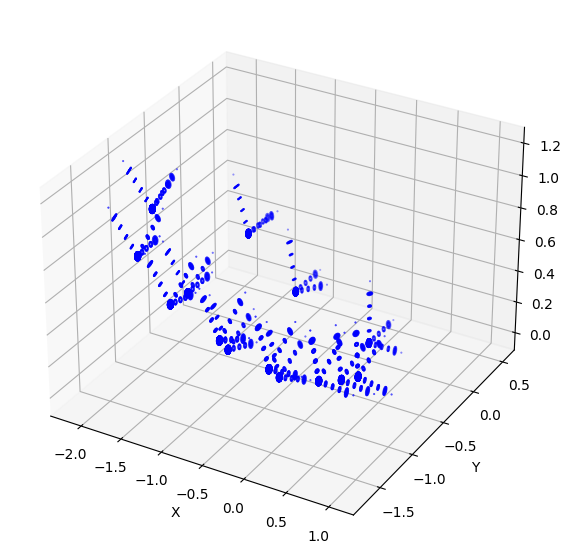

In [ ]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np

# Load your PLY file
point_cloud = o3d.io.read_point_cloud("/content/cameras_14.ply")  # Make sure to upload your PLY file to Colab and replace the path

# Convert Open3D.o3d.geometry.PointCloud to numpy array
points = np.asarray(point_cloud.points)

# Plot using matplotlib
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='blue', marker='.')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()
